In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# copy processing script to curdir
!cp ../input/suicide-ideation/preprocess.py .

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

import preprocess

In [ ]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

BASE_DIR = "../input/suicide-ideation"
df_1 = pd.read_csv(BASE_DIR+"/more_data_3.csv") # train_dataset
df_2 = pd.read_csv(BASE_DIR+"/data_full.csv") # dataset2

In [ ]:
print(df_1.dtypes)
df_1.head(3)

text     object
label     int64
dtype: object


,text,label
0,truly wanted kill wasn seeking attention d t...,1
1,girlfriend killed week broke hello know start...,1
2,want die want kill wish stop existing,1


In [ ]:
print(df_1.shape, df_2.shape)
df_2.head()

(11338, 2) (1895, 14)


,Unnamed: 0,Unnamed: 0.1,title,selftext,author,num_comments,is_suicide,url,selftext_clean,title_clean,author_clean,selftext_length,title_length,megatext_clean
0,0,339,Need help,Hi I don't really know how to phrase this situ...,F4GG0T_,6,0,https://www.reddit.com/r/depression/comments/f...,hi really know phrase situation try life reall...,need help,f 4 gg 0,2502,9,f 4 gg 0 hi really know phrase situation try l...
1,1,1386,feeling so overwhelmed and hopeless,i have been so depressed these past couple wee...,thiccbarbie420,2,1,https://www.reddit.com/r/SuicideWatch/comments...,depressed past couple week ever since got back...,feeling overwhelmed hopeless,th icc barbie 420,843,35,th icc barbie 420 depressed past couple week e...
2,2,544,"Nothing matters anymore, getting worse",Hi..I don't know where else to go. I am devast...,mjdg25,3,0,https://www.reddit.com/r/depression/comments/f...,hi know else go devastated right feeling like ...,nothing matter anymore getting worse,mj g 25,1909,38,mj g 25 hi know else go devastated right feeli...
3,3,937,Who’s tired of hearing bullshit,"The shit like “it will get better, everyone is...",fuckxboxandgames,4,1,https://www.reddit.com/r/SuicideWatch/comments...,shit like get better everyone purpose need fin...,tired hearing bullshit,fuck xbox game,403,31,fuck xbox game shit like get better everyone p...
4,4,741,I wish I was someone else.,I wish I was prettier. I wish I didn’t feel li...,Throwawaybluestahli,1,0,https://www.reddit.com/r/depression/comments/f...,wish wa prettier wish feel like burden wish br...,wish wa someone else,throwaway bluest ahli,321,26,throwaway bluest ahli wish wa prettier wish fe...


The train dataset contains 2 feature columns and `11338` documents each in their respective corpus.
The text represents the contents of each post.
The `label` column represents whether a given post is `suicidal` or `non-suicidal`/depression. These are the major features we'll be using as our predictors.

Text(0.5, 1.0, 'Train data (df_1) class distribution.')

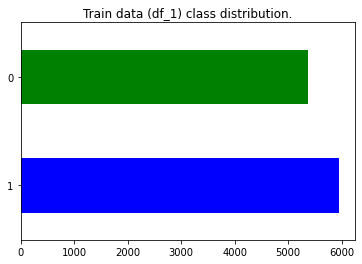

In [ ]:
# Analyze class distributions
# This is a binary classification problem and so there's only two classes involved
# i.e. suicidal and non-suicidal/depression
df_1["label"].value_counts().plot(kind='barh', color=('b','g'))
plt.title("Train data (df_1) class distribution.")

The class distribution is almost balanced as depicted in the plot above but we account for the slight skewness in distribution by applying stratified sampling to ensure equal class representations in train batches.

In [ ]:
## Clean raw data file df_2
cols = ["text", "label"]
df_1['text'] = df_1["text"].apply(preprocess.remove_html)
df_1["text"] = df_1["text"].apply(preprocess.remove_URL)
df_1["text"] = df_1["text"].apply(preprocess.clean_text)
df_1["text"] = df_1["text"].apply(preprocess.remove_emojis)

df_1 = df_1.dropna(axis=0)
df_2 = df_2.dropna(axis=0)

### Word Frequency Analysis
* Analyze the most frequently occuring words in both suicidal and non-suicidal text clusters.

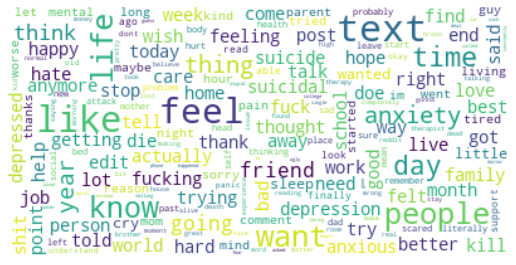

In [ ]:
# Suicidal word frequency analysis
suicidal = df_1[df_1['label']==1]
most_frequent = pd.Series(' '.join(suicidal['text']).split()).value_counts()[:500]
wordcloud = WordCloud(background_color="white",max_font_size=30).generate_from_frequencies(most_frequent)

plt.figure(figsize = (9, 6)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

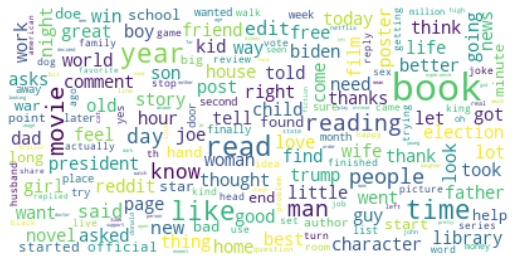

In [ ]:
# Non-suicidal text word frequency
non_suicidal = df_1[df_1['label']==0]
frequency = pd.Series(' '.join(non_suicidal['text']).split()).value_counts()[:500]
wordcloud = WordCloud(background_color="white",max_font_size=30).generate_from_frequencies(frequency)

plt.figure(figsize = (9, 6)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Baseline model training
* Train Logistic Regression and Xgboost models for suicidal intent classification

In [ ]:
#features = [["title", "selftext", "is_suicide"]]
features = df_1["text"]
target = df_1["label"]

## Create train and test vectors
## Machine learning algorithms can only decode numerical data formats and thus
## the text from user posts has to be converted into a numeric type
## We use scikit-learn's TfIDF vectorizer to do this.
## TfIDF generates a vector of term-inverse document frequencies of words in each document in the corpus
train_vectors, vectorizer = preprocess.vectorize(features)

# Map the tokens in the train vectors to the test set. 
# i.e.the train and test vectors use the same set of tokens.
test_vectors = vectorizer.transform(df_2['selftext_clean'])

In [ ]:
# Model definition
logreg = LogisticRegression(C=10.0,
                            max_iter=1000,
                            random_state=42
                           )

# Model training with Cross-Validation
lscores = []
kf = StratifiedKFold(5, shuffle=True, random_state=1)

for i, (tr, val) in enumerate(kf.split(train_vectors, target)):
    X_tr, y_tr = train_vectors[tr], np.take(target, tr, axis=0)
    X_val, y_val = train_vectors[val], np.take(target, val, axis=0)
    
    logreg.fit(X_tr, y_tr)
    score = f1_score(y_val, logreg.predict(X_val))
    lscores.append(score)
    print(score)
print(f'Mean_F1: {np.mean(lscores)}')

0.9624893435635123
0.9691070672873466
0.9622401357658039
0.9552620366425224
0.9600679694137637
Mean_F1: 0.9618333105345899


In [ ]:
# Predict on test set with logistic regression model
lpredictions = logreg.predict(test_vectors)
test_score = f1_score(df_2['is_suicide'], lpredictions)
print(f"Test F1_score: {test_score}")
print(f"Test Accuracy_score: {accuracy_score(df_2['is_suicide'], lpredictions)}")

Test F1_score: 0.6133540372670807
Test Accuracy_score: 0.46794871794871795


In [ ]:
# Model definition
xgb_clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=150,
                            colsample_bytree=0.9, 
                            subsample=0.9,
                            nthread=2,
                            learning_rate=0.1,
                            random_state=42
                            )

# Model training with Cross-Validation
scores = []
kf = StratifiedKFold(5, shuffle=False) #, random_state=1)

for i, (tr, val) in enumerate(kf.split(train_vectors, target)):
    X_tr, y_tr = train_vectors[tr], np.take(target, tr, axis=0)
    X_val, y_val = train_vectors[val], np.take(target, val, axis=0)
    
    xgb_clf.fit(X_tr, y_tr)
    score = f1_score(y_val, xgb_clf.predict(X_val))
    scores.append(score)
    print(score)
print(f'Mean_F1: {np.mean(scores)}')

0.8300242130750605
0.8911533117183881
0.9487964989059081
0.944114149821641
0.9418742586002372
Mean_F1: 0.9111924864242471


In [ ]:
# Predict on test set
predictions = xgb_clf.predict(test_vectors)
test_score = f1_score(df_2['is_suicide'], predictions)
print(f"Test F1_score: {test_score}")
print(f"Test Accuracy_score: {accuracy_score(df_2['is_suicide'], predictions)}")

Test F1_score: 0.5914707054603429
Test Accuracy_score: 0.45245726495726496


This being a binary classification task, the evaluation metrics chosen to measure the model performance were classification metrics of f1 and accuracy as we want to determine the percentage of matching class predictions to the original classes in the test/validation datasets.
StratifiedKFold cross validation is used to generate representative data samples per class from the population for the model to train on and thus try to ensure that it will generalize well (low bias) to unseen data.

### Convolutional Attention Model with Label Correction
* Apply threshold based label correction to the train and test dataset labels to try to improve the correctness of the labels.
* We use predictions from the logistic regression `logreg` model to tune the labels of the train and test sets since it achieves a better test performance compared to the xgboost classifier model.

In [ ]:
# This technique is inspired by this research paper: https://arxiv.org/abs/2102.09427
train_labels = np.asarray(target)
test_labels = np.asarray(df_2['is_suicide'])

# test set label predictions
predicted_labels = np.asarray(predictions)
predicted_probs = np.asarray(logreg.predict_proba(test_vectors)[:,1])
# train set label predictions
predicted_train_labels = logreg.predict(train_vectors) # train set
predicted_train_probs = np.asarray(logreg.predict_proba(train_vectors)[:,1]) # predicted probabilities

def LabelCorrection(labels, predicted, probabilities, tau=0.85):
    """
    Perform label correction using a set of input labels
    and predicted labels from a baseline classification model.
    Args:
        `labels`: input/original labels
        `predicted`: predicted labels
        `probabilities`: predicted label probabilities
        `tau`: threshold value
        
    """
    corrected_labels = []
    for i in range(len(labels)):
        if labels[i] != predicted[i]: #train_labels, predicted_train_labels
            if probabilities[i] > tau or probabilities[i] < (1 - tau): #predicted_train_probs
                corrected_labels.append(predicted[i])
            else:
                corrected_labels.append(labels[i])
        else:
            corrected_labels.append(labels[i])
    corrected_labels = np.asarray(corrected_labels)
    
    return corrected_labels

final_train_labels = LabelCorrection(train_labels, predicted_train_labels, predicted_train_probs)
final_test_labels = LabelCorrection(test_labels, predicted_labels, predicted_probs)

In [ ]:
# Model training with Cross-Validation
scores = []
kf = KFold(5, shuffle=True, random_state=42)
logreg = LogisticRegression(C=1.0,
                            max_iter=1000,
                            random_state=42
                           )
for i, (tr, val) in enumerate(kf.split(train_vectors, final_train_labels)):
    X_tr, y_tr = train_vectors[tr], np.take(final_train_labels, tr, axis=0)
    X_val, y_val = train_vectors[val], np.take(final_train_labels, val, axis=0)
    
    logreg.fit(X_tr, y_tr)
    score = f1_score(y_val, logreg.predict(X_val))
    scores.append(score)
    print(score)
print(f'Mean_F1: {np.mean(scores)}')

0.9676606467870643
0.9617996604414262
0.965635738831615
0.9647058823529411
0.9574844995571302
Mean_F1: 0.9634572855940353


In [ ]:
# Predict on test set with logistic regression model
lpredictions = logreg.predict(test_vectors)
test_score = f1_score(final_test_labels, lpredictions)
print(f"Test F1_score: {test_score}")
print(f"Test Accuracy_score: {accuracy_score(final_test_labels, lpredictions)}")

Test F1_score: 0.9396744334503672
Test Accuracy_score: 0.8990384615384616


### The Convolutional-Attention (CA) Model
* Prepare data/text for sequence prediction using the CA-model
* Define the model architecture and train the model

In [ ]:
# df_2["selftext"], df_2['is_suicide'] - testset
# Split dataset into train and validation sets (df_1)
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    final_train_labels, #target,
                                                    stratify=target,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

## get train and test corpus
train_corpus = X_train.tolist()
test_corpus = X_test.tolist()

## Convert labels back to int
y_train = np.array(list(map(int, y_train.tolist())))
y_test = np.array(list(map(int, y_test.tolist())))

#test set
test_feat_corpus = list(df_2["selftext"])

# text & token lengths
token_len = [len(x.split(" ")) for x in train_corpus]
text_len = [len(x) for x in train_corpus]
print(f'Max token len: {max(token_len)},\nMin token len: {min(token_len)}\nMean token len: {np.mean(token_len)}\nMax text len: {max(text_len)}')

Max token len: 3954,
Min token len: 1
Mean token len: 25.822491730981255
Max text len: 27646


In [ ]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"&()*+,-./:;<=>?[\\]^_`{|}~\t\'',
                                                  lower=True
                                                  )
tokenizer.fit_on_texts(train_corpus)
vocab_size = len(tokenizer.word_counts)
print(f'Train Vocabulary size: {vocab_size}')

max_seq_len = 55 #96 #200 #100 #48 #max(token_len)  
train_seq = tokenizer.texts_to_sequences(train_corpus)
test_seq = tokenizer.texts_to_sequences(test_corpus)

test_feat_seq = tokenizer.texts_to_sequences(test_feat_corpus)
## setting the vocabulary size
#vocab_size = 10000

## Pad sequences to equal lengths
train_padded_seq = pad_sequences(train_seq, maxlen=max_seq_len, dtype='int32')
test_padded_seq = pad_sequences(test_seq, maxlen=max_seq_len, dtype='int32')
test_feat_padded_seq = pad_sequences(test_feat_seq, maxlen=max_seq_len, dtype='int32')

Train Vocabulary size: 19137


In [ ]:
# Download glove vectors
URL = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip" #"https://nlp.stanford.edu/data/glove.6B.zip"

def extract_glove_files(file_, delete_zip=False):
    """Unzip input target file."""
    import zipfile

    #extract zip_file
    zf = zipfile.ZipFile(file_)
    print(f" Extracting {file_} file")
    zf.extractall()

    # Delete original zip
    if delete_zip:
        print(f" Remove zip {file_+'.zip'} file")
        os.remove(path=zip_file)

def download_glove(url=None, file_="./glove.zip"):
    import tqdm
    import requests

    #if the dataset already exists exit
    if os.path.isfile(file_):
        #if os.path.exists(BASE_DIR+"/data/glove"):
        print("dataset already downloded and extracted :) ")
        return

    print("-"*80)
    print("  Downloading Glove vectors")
    print("-"*80)
    response = requests.get(url, stream=True)
    #read and write chunk by chunk
    handle = open(file_, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()
    print("  Download complete ;) :")
        
    #extract files
    extract_glove_files(file_)

#download_glove(url=URL) 

In [ ]:
## Load and initialize pretrained glove vectors for model training
vector_path = "../input/glove840b300dtxt/glove.840B.300d.txt"

embedding_index = dict()

with open(vector_path) as vectors:
    for line in vectors:
        values = line.strip().split()
        word = " ".join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embedding_index[word] = coefs.reshape(-1)

print(f'Pretrained word vector size: {len(embedding_index)}')

Pretrained word vector size: 2195896


In [ ]:
## Create an embedding weights matrix for words in train data
embed_size = 300 # the dimension of the glove vectors
embedding_matrix = np.zeros((vocab_size, embed_size))
for word, i in tokenizer.word_index.items():
    try:
        if i >= vocab_size:
            continue
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue
        
print(embedding_matrix.shape)

(19137, 300)


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

class Attention(Layer):
    # taken from https://www.kaggle.com/code/takuok/bidirectional-lstm-and-attention-lb-0-043/notebook
    def __init__(self,
                 step_dim,
                 W_regularizer=None,
                 b_regularizer=None,
                 W_constraint=None,
                 b_constraint=None,
                 bias=True,
                 **kwargs
                 ):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "step_dim": self.step_dim,
            "W_regularizer": self.W_regularizer,
            "b_regularizer": self.b_regularizer,
            "W_constraint": self.W_constraint,
            "b_constraint": self.b_constraint,
            "bias": self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [ ]:
def TPUSetup():
    """Configure TPU."""
    print('=========Configuring TPU=========')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print('=========Finished TPU configuration=========')
    except ValueError:
        # default to CPU and single GPU if TPU isn't detected
        strategy = tf.distribute.get_strategy()
    print('Number of replicas in sync:', strategy.num_replicas_in_sync)
    return strategy 

#strategy = TPUSetup()
#BATCH_SIZE= 16 * strategy.num_replicas_in_sync #ensures utilization of all tpu cores for training speedup
#AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
def build_convnet(vocab, seq_len, emb_size):
    """Defines and returns a convnet model."""
    input_ = layers.Input(shape=(seq_len,))
    static_embedding = layers.Embedding(vocab,
                                        embedding_matrix.shape[1], #embedding_size
                                        weights=[embedding_matrix],
                                        input_length=seq_len,
                                        trainable=False,
                                        name="static_embedding"
                                        )
    dynamic_embedding = layers.Embedding(vocab,
                                         embedding_matrix.shape[1],
                                         weights=[embedding_matrix],
                                         input_length=seq_len,
                                         trainable=True,
                                         name="dynamic_embedding"
                                        )
    ## Static channel
    c5_embedding = static_embedding(input_)
    c4_embedding = static_embedding(input_)
    c3_embedding = static_embedding(input_)
    #x = layers.Convolution1D(300, 5, padding='same', activation='relu')(embedding)
    c5 = layers.Convolution1D(300, 5, padding='same', activation='relu', name='conv_5grams')(c5_embedding)
    att5 = Attention(seq_len)(c5)
    
    c4 = layers.Convolution1D(300, 4, padding='same', activation='relu', name='conv_4grams')(c4_embedding)
    att4 = Attention(seq_len)(c4)
    print(att5.shape, att5)
    
    c3 = layers.Convolution1D(300, 3, padding='same', activation='relu', name='conv_3grams')(c3_embedding)
    att3 = Attention(seq_len)(c3)
    s_concat = layers.concatenate([att5, att4, att3], axis=-1, name='static_channel_attention_heads_concat')
    
    ## Dynamic channel
    dc5_embedding = dynamic_embedding(input_)
    dc4_embedding = dynamic_embedding(input_)
    dc3_embedding = dynamic_embedding(input_)

    dc5 = layers.Convolution1D(300, 5, padding='same', activation='relu', name='dconv_5grams')(dc5_embedding)
    datt5 = Attention(seq_len)(dc5)
    
    dc4 = layers.Convolution1D(300, 4, padding='same', activation='relu', name='dconv_4grams')(dc4_embedding)
    datt4 = Attention(seq_len)(dc4)
    
    dc3 = layers.Convolution1D(300, 3, padding='same', activation='relu', name='dconv_3grams')(dc3_embedding)
    datt3 = Attention(seq_len)(dc3)
    d_concat = layers.concatenate([datt5, datt4, datt3], axis=-1, name='dynamic_channel_attention_heads_concat')
    
    #x = Attention(seq_len)(x)
    #x = layers.Dense(256, activation='relu')(x)
    stat_dynamic_concat = layers.concatenate([s_concat, d_concat]) # static-dynamic channel concatenation
    x = layers.Dropout(0.25)(stat_dynamic_concat)
    out = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_, outputs=out)
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy']
                  )
    return model

# Creating the model on TPU
#with strategy.scope():
ca_model = build_convnet(embedding_matrix.shape[0], max_seq_len, embed_size) #vocab_size[0]
ca_model.summary()

2022-06-17 06:19:47.930969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 06:19:47.935914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 06:19:47.936634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 06:19:47.937646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(None, 300) KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name=None), name='attention/Sum_1:0', description="created by layer 'attention'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
static_embedding (Embedding)    (None, 55, 300)      5741100     input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dynamic_embedding (Embedding)

In [ ]:
weights_path = './ca_model_50ep_1e-4lr.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path,
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min', 
                                                save_weights_only=False
                                               )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min',
                                                  patience=8
                                                  )

callbacks_ = [early_stopping, checkpoint]

def train_ca_model(model):
    """
    Train ConvNet_attention(ca) model for suicide intent classification.
    """ 
    history = model.fit(train_padded_seq,
                        y_train,
                        validation_data=(test_padded_seq, y_test),
                        epochs=50,
                        batch_size=8,
                        callbacks=callbacks_
                        )
    return history

%time history = train_ca_model(ca_model)

2022-06-17 06:19:53.140334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-17 06:19:55.946692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1134/1134 [==============================] - 20s 10ms/step - loss: 0.1915 - accuracy: 0.9463 - val_loss: 0.0866 - val_accuracy: 0.9709

Epoch 00001: val_loss improved from inf to 0.08656, saving model to ./ca_model_50ep_1e-4lr.h5


2022-06-17 06:20:13.538077: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22964400 exceeds 10% of free system memory.
2022-06-17 06:20:13.591733: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22964400 exceeds 10% of free system memory.
2022-06-17 06:20:13.634203: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22964400 exceeds 10% of free system memory.
2022-06-17 06:20:13.653063: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22964400 exceeds 10% of free system memory.


Epoch 2/50
1134/1134 [==============================] - 12s 10ms/step - loss: 0.0609 - accuracy: 0.9792 - val_loss: 0.0767 - val_accuracy: 0.9740

Epoch 00002: val_loss improved from 0.08656 to 0.07674, saving model to ./ca_model_50ep_1e-4lr.h5
Epoch 3/50
1134/1134 [==============================] - 11s 10ms/step - loss: 0.0399 - accuracy: 0.9874 - val_loss: 0.0793 - val_accuracy: 0.9718

Epoch 00003: val_loss did not improve from 0.07674
Epoch 4/50
1134/1134 [==============================] - 11s 10ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.0836 - val_accuracy: 0.9696

Epoch 00004: val_loss did not improve from 0.07674
Epoch 5/50
1134/1134 [==============================] - 11s 10ms/step - loss: 0.0187 - accuracy: 0.9954 - val_loss: 0.0831 - val_accuracy: 0.9718

Epoch 00005: val_loss did not improve from 0.07674
Epoch 6/50
1134/1134 [==============================] - 11s 10ms/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.0869 - val_accuracy: 0.9718

Epoch 00006: v

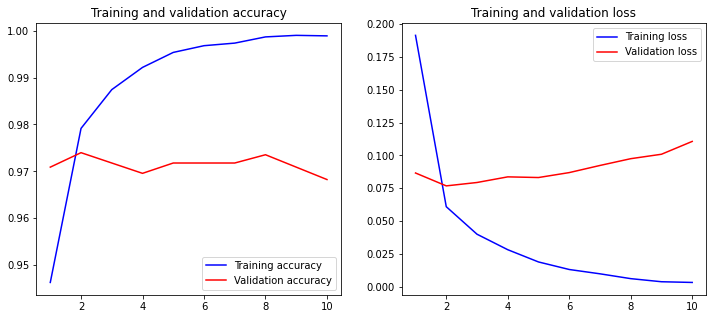

In [ ]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [ ]:
ca_model.load_weights('./ca_model_50ep_1e-4lr.h5')
%time _, accuracy = ca_model.evaluate(test_feat_padded_seq, final_test_labels)

59/59 [==============================] - 0s 5ms/step - loss: 0.4189 - accuracy: 0.8814
CPU times: user 382 ms, sys: 14 ms, total: 396 ms
Wall time: 663 ms


In [ ]:
ca_predictions = ca_model.predict(test_feat_padded_seq)
threshold = 0.5
final_preds = [0]*len(ca_predictions)
for i in range(len(ca_predictions)):
    if ca_predictions[i] >= threshold:
        final_preds[i] = 1
    else:
        final_preds[i] = 0

final_score = f1_score(final_preds, final_test_labels)
print(f"Test F1_Score: {final_score}")
print(f"Test Accuracy: {accuracy}")

Test F1_Score: 0.9312693498452013
Test Accuracy: 0.8814102411270142
